In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. If I don't do this the code gives an unneccesary warning (in my view) when I'm standardising data in a dataframe.
from tabulate import tabulate
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim

## Overview Of This Jupyter Notebook

The purpose of this notebook is to try and use a variety of machine learning tools to model price-to-earnings ratios for a selection of stocks (global consumer staples and consumer discretionary with a market capitalisation > USD 500mn).

- **Section One:** I get the data, conduct some exploratory data analysis and remove outliers and missing numbers. I also split the data to form train, validate and test segments.

- **Section Two:** I explore using a random forest approach to model the data and optimise relevant hyperparameters.

- **Section Three:** I explore using a neural network to model the data and optimise relevant hyperparameters.

- **Section Four:** I conduct a basic linear regression for comparison.

- **Section Five:** I conclude and summarise my findings.

## Section One: Data Exploration

Here I get data, conduct exploratory data analysis and prepare the data for the models.

In [2]:
# load the dataset
dataset_df = pd.read_csv('C:/...path_to_data', sep=',')

In [3]:
dataset_df

,Ticker,Est Rev CAGR (3Y),Est EBIT CAGR (3Y),Hist Rev CAGR (5Y),Hist Rev CAGR (3Y),Hist EBIT CAGR (3Y),ROIC (FY),Gross Profit Margin % (FY),EBIT Margin % (FY),Net Income Margin % (FY),FCF Margin % (FY),Net Debt / EBITDA (FY),Volume (% SO),Country_Code,Industry_Code,P/E (NTM)
0,Stock-5551634,-0.0148,0.1186,0.1299,0.0582,-0.9041,-0.0080,0.0999,0.0000,0.0095,0.0117,4.697642,0.005369,AU,Cons_Stap_Dist_Retail,14.6
1,Stock-4132665,0.1452,2.4989,0.0287,0.0373,-0.7425,0.0034,0.0969,0.0035,-0.0052,-0.0292,7.006980,0.006827,TH,Auto_Comps,10.7
2,Stock-6933651,0.0250,1.4408,-0.0258,-0.1194,-0.7043,-0.0268,0.3028,0.0023,-0.0279,-0.0841,-6.982301,0.028116,CN,Beverages,29.3
3,Stock-7134137,0.1384,0.8801,0.0159,0.0154,-0.5843,0.0050,0.6200,0.0171,0.0444,0.0907,-28.165008,0.000700,CN,HH_Products,145.0
4,Stock-4295881,0.1208,1.6909,0.0645,0.0290,-0.5627,-0.0019,0.1904,0.0037,0.0014,0.0246,0.311231,0.005444,RoW,Specialty_Retail,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,Stock-1691179755,0.0327,0.1256,0.0545,0.1186,2.2860,0.1050,0.3869,0.0720,0.0323,0.0772,1.198107,0.024674,US,Specialty_Retail,10.3
1179,Stock-6261180611,0.4263,0.5828,0.6205,1.2204,2.4608,0.2071,0.4820,0.1274,0.0678,0.1445,-0.682280,0.011903,RoW,Textiles_Apparel_Lux_Goods,6.8
1180,Stock-5431181848,-0.1468,-0.2884,0.1856,0.3578,2.6934,0.3433,0.6777,0.4358,0.3082,0.1649,0.288080,0.004654,US,Hot_Rest_Leisure,20.9
1181,Stock-4161182762,0.2297,0.2191,0.5507,1.0330,2.9415,0.1719,0.1946,0.0970,0.0910,0.0379,-3.444484,0.005273,CN,Auto_Comps,18.3


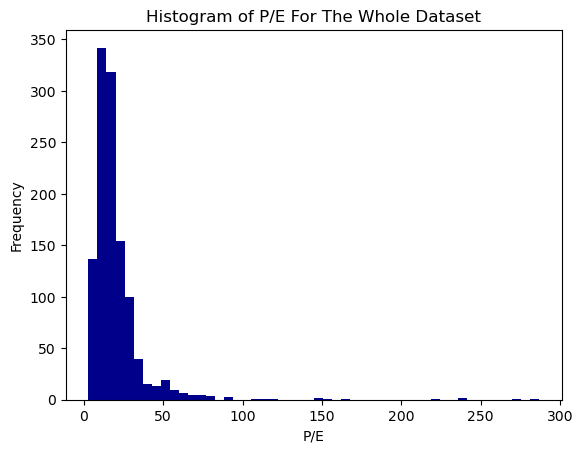

In [4]:
# Look at a basic histogram of the P/E data.
plt.hist(dataset_df['P/E (NTM)'], bins=50, color='darkblue')
plt.xlabel("P/E")
plt.ylabel("Frequency")
plt.title("Histogram of P/E For The Whole Dataset")
plt.show()

**Additional Data Cleaning**

I've decided to make two further steps to clean the data. First, upon closer inspection I saw that there is a NAN value in the Net Debt / EBITDA column for row 100. I will remove that row. Second, as we can see in the chart above there is a long tail of PER values above 100. I think it makes sense to treat these as outliers and remove them.

In [5]:
# Drop the NaN value in 600 row.
dataset_df.drop(dataset_df.index[600], inplace = True)

In [6]:
# Filter the dataframe to have rows only where the PER is less than or equal to 100.
dataset_df = dataset_df[dataset_df['P/E (NTM)'] <= 100]

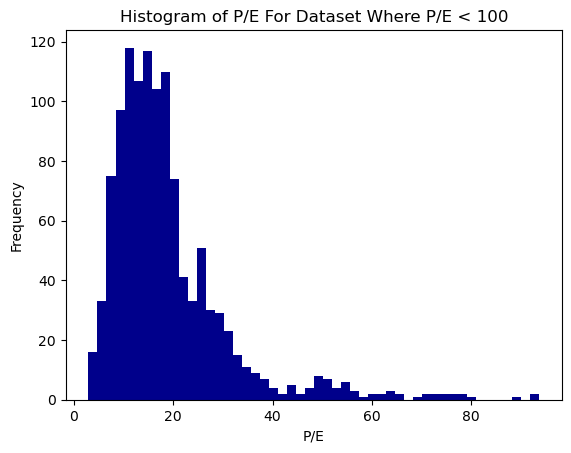

In [7]:
# Chart PER again with the tail of stocks with a PER of higher than 100 removed.
plt.hist(dataset_df['P/E (NTM)'], bins=50, color='darkblue')
plt.xlabel("P/E")
plt.ylabel("Frequency")
plt.title("Histogram of P/E For Dataset Where P/E < 100")
plt.show()

**Average P/E By Country And Industry**

In the table below I make a heat plot of the average P/E by country and industry. As you can see stocks in India are more highly valued than average and so I add a dummy variable for Indian stocks. Note that some of the squares are white because no data is available.

[Text(0.5, 1.0, 'Average P/E By Country And Industry')]

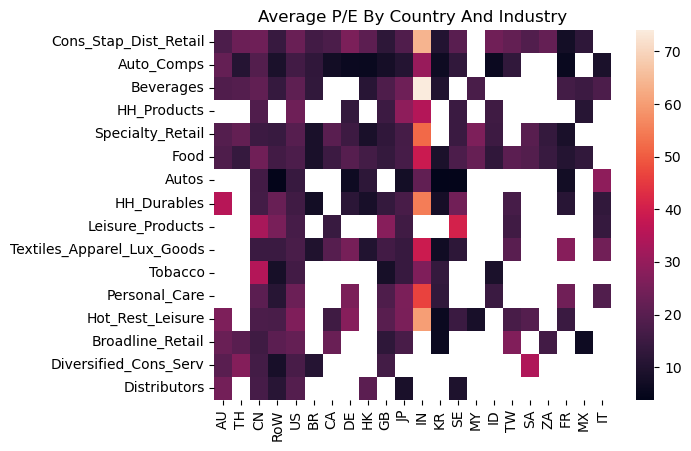

In [8]:
# In this code I make a table to look at the average P/E by country and industry.

countries = dataset_df['Country_Code'].unique()
industries = dataset_df['Industry_Code'].unique()

averages = {'AU' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'TH' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'CN' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'RoW' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'US' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'BR' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'CA' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'DE' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'HK' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'GB' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'JP' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'IN' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'KR' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'SE' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'MY' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'ID' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'TW' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'SA' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'ZA' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'FR' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'MX' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0],
           'IT' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0]}

averages_table = pd.DataFrame(averages, dtype=np.float64)

averages_table.index = ['Cons_Stap_Dist_Retail', 'Auto_Comps', 'Beverages', 'HH_Products',
       'Specialty_Retail', 'Food', 'Autos', 'HH_Durables',
       'Leisure_Products', 'Textiles_Apparel_Lux_Goods', 'Tobacco',
       'Personal_Care', 'Hot_Rest_Leisure', 'Broadline_Retail',
       'Diversified_Cons_Serv', 'Distributors']

for i in countries:
    for j in industries:
        number_use = dataset_df.loc[(dataset_df['Country_Code'] == i) & (dataset_df['Industry_Code'] == j), 'P/E (NTM)'].mean()
        if math.isnan(number_use):
            averages_table.loc[j,i] = float('nan')
        else:
            averages_table.loc[j,i] = round(number_use,1)

pd.options.display.max_columns = 25

sb.heatmap(averages_table).set(title = "Average P/E By Country And Industry")

In [9]:
# In the following section I make a correlation matrix for the independent variables (features).
dataset_corr = dataset_df.drop('Ticker', axis=1)
dataset_corr = dataset_corr.drop('Country_Code', axis=1)
dataset_corr = dataset_corr.drop('Industry_Code', axis=1)
dataset_corr = dataset_corr.drop('P/E (NTM)', axis=1)
dataset_corr

,Est Rev CAGR (3Y),Est EBIT CAGR (3Y),Hist Rev CAGR (5Y),Hist Rev CAGR (3Y),Hist EBIT CAGR (3Y),ROIC (FY),Gross Profit Margin % (FY),EBIT Margin % (FY),Net Income Margin % (FY),FCF Margin % (FY),Net Debt / EBITDA (FY),Volume (% SO)
0,-0.0148,0.1186,0.1299,0.0582,-0.9041,-0.0080,0.0999,0.0000,0.0095,0.0117,4.697642,0.005369
1,0.1452,2.4989,0.0287,0.0373,-0.7425,0.0034,0.0969,0.0035,-0.0052,-0.0292,7.006980,0.006827
2,0.0250,1.4408,-0.0258,-0.1194,-0.7043,-0.0268,0.3028,0.0023,-0.0279,-0.0841,-6.982301,0.028116
4,0.1208,1.6909,0.0645,0.0290,-0.5627,-0.0019,0.1904,0.0037,0.0014,0.0246,0.311231,0.005444
5,0.0349,0.2305,0.0853,0.0887,-0.4902,0.0042,0.0478,0.0060,0.0113,0.0168,7.780336,0.001542
...,...,...,...,...,...,...,...,...,...,...,...,...
1178,0.0327,0.1256,0.0545,0.1186,2.2860,0.1050,0.3869,0.0720,0.0323,0.0772,1.198107,0.024674
1179,0.4263,0.5828,0.6205,1.2204,2.4608,0.2071,0.4820,0.1274,0.0678,0.1445,-0.682280,0.011903
1180,-0.1468,-0.2884,0.1856,0.3578,2.6934,0.3433,0.6777,0.4358,0.3082,0.1649,0.288080,0.004654
1181,0.2297,0.2191,0.5507,1.0330,2.9415,0.1719,0.1946,0.0970,0.0910,0.0379,-3.444484,0.005273


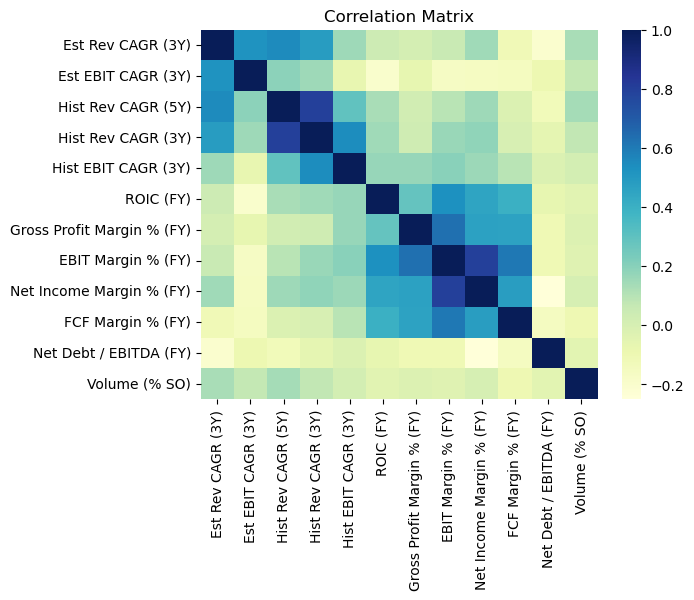

In [10]:
dataplot = sb.heatmap(dataset_corr.corr(numeric_only=True), cmap="YlGnBu", annot=False).set(title = "Correlation Matrix")

**First Run A Basic Linear Regression**

I'm not sure if this is "best practice". However, here I run a simple linear regression across the whole dataset to get a sense of whether there are any variables that aren't necessary for the model.

**Simplify The Problem And Drop Unnecessary Features/Variables**

The results from the regression below suggest that:

(1) The India dummy variable is highly statistically significant so I will keep that as a variable.

(2) The historic growth figures are quite messy and the sign on 3Y revenue growth is counterintuitive. When the India dummy variable is dropped none of the historic figures are statistically significant. Arguably we shouldn't need historic growth figures because markets are foward looking and we have forward estimates for growth in the model. I will drop all of the historic growth variables as features for these reasons.

(3) Gross and EBIT margin do seem somewhat relevant but net income and FCF margin don't seem relevant. I suspect that this is because on a one year basis net income and FCF can be more volatile. I drop both.

(4) I keep net debt/EBITDA because it is intuitively important and it might be that the relationship with P/E is non-linear.

In [11]:
dummies = pd.get_dummies(dataset_df['Country_Code'], dtype='int')
dataset_df.insert(1, "IN_DVar", dummies['IN'],True)

In [12]:
# For standard linear regressions we don't need to normalise the data.
# Regression includes the India dummy variable.

X_reg = dataset_df[['IN_DVar','Est Rev CAGR (3Y)','Est EBIT CAGR (3Y)','Hist Rev CAGR (5Y)','Hist Rev CAGR (3Y)','Hist EBIT CAGR (3Y)','ROIC (FY)','Gross Profit Margin % (FY)','EBIT Margin % (FY)','Net Income Margin % (FY)','FCF Margin % (FY)','Net Debt / EBITDA (FY)','Volume (% SO)']]
y_reg = dataset_df[['P/E (NTM)']]

reg = LinearRegression().fit(X_reg, y_reg)
y_lin = reg.predict(X_reg)

X2 = sm.add_constant(X_reg)
est = sm.OLS(y_reg, X2)
est_TWO = est.fit()
print(est_TWO.summary())

                            OLS Regression Results                            
Dep. Variable:              P/E (NTM)   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     40.02
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           4.79e-84
Time:                        09:47:40   Log-Likelihood:                -4387.9
No. Observations:                1170   AIC:                             8804.
Df Residuals:                    1156   BIC:                             8875.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [13]:
# Create the starting data that we need in a dataframe.

X_nn_input = dataset_df[['Est Rev CAGR (3Y)','Est EBIT CAGR (3Y)','ROIC (FY)','Gross Profit Margin % (FY)','EBIT Margin % (FY)','Net Debt / EBITDA (FY)','Volume (% SO)']]
y_nn_input = dataset_df[['P/E (NTM)']]
# I'm saving this for the final chart.
y_nn_input_save = dataset_df[['P/E (NTM)']]
# Normalise the data. I've used the z-score method here.

for column in X_nn_input.columns: 
    X_nn_input[column] = (X_nn_input[column] - X_nn_input[column].mean()) / X_nn_input[column].std()

# Add in the Indian dummy variable. I didn't standardise this because it is a dummy variable.

X_nn_input.insert(0, "IN_DVar", dummies['IN'],True)

y_mean = y_nn_input['P/E (NTM)'].mean()
y_std = y_nn_input['P/E (NTM)'].std()

y_nn_input['P/E (NTM)'] = (y_nn_input['P/E (NTM)'] - y_nn_input['P/E (NTM)'].mean()) / y_nn_input['P/E (NTM)'].std()


In [14]:
# Use train_test_split twice to get train, validate and test sets.

X_train_1, X_test, y_train_1, y_test = train_test_split(X_nn_input, y_nn_input, test_size = 0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, test_size = 0.18, random_state=1)

In [15]:
# Convert the datafram to numpy and then to a tensor.
# Note that the dimensions in the numpy arrays here are 2D. This isn't a problem for the neural net but it is for random forest.

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

## Section Two: Random Forest

I explore using a random forest model.

For the hyperparameter tuning I am going to focus on n_estimators and max_depth as the two hyperparameters that are the most important to tune.

In [16]:
# Set up the random forest regression classifier.

y_train_random_forest = y_train_np.flatten()
y_val_random_forest = y_val_np.flatten()

# The n_estimators hyperparameter is the number of decision trees used.
number_of_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# The max_depth hyperparameter is the maximum depth that trees are allowed to reach.
maximum_depths = [5, 10, 15, 20, 25, 30, 35, 40]

rmse_rf_min = 10

for estimators in number_of_estimators:
    for depths in maximum_depths:
        random_forest_classifier = RandomForestRegressor(n_estimators=estimators, max_depth = depths, random_state=0, oob_score=False)
        random_forest_classifier.fit(X_train_np, y_train_random_forest)
        rmse_rf = root_mean_squared_error(y_val_random_forest, random_forest_classifier.predict(X_val_np))
        if rmse_rf < rmse_rf_min:
            rmse_rf_min = rmse_rf
            print("number of estimators:",estimators," and ","maximum depth:",depths," and ","RMSE:",root_mean_squared_error(y_val_random_forest, random_forest_classifier.predict(X_val_np)))

number of estimators: 10  and  maximum depth: 5  and  RMSE: 0.9320468878376095
number of estimators: 20  and  maximum depth: 5  and  RMSE: 0.9226489658821015
number of estimators: 30  and  maximum depth: 5  and  RMSE: 0.9128260072732498
number of estimators: 40  and  maximum depth: 5  and  RMSE: 0.911307292259828
number of estimators: 40  and  maximum depth: 20  and  RMSE: 0.9082309566862504
number of estimators: 50  and  maximum depth: 20  and  RMSE: 0.9074792909300603
number of estimators: 60  and  maximum depth: 5  and  RMSE: 0.9072908448023905
number of estimators: 60  and  maximum depth: 20  and  RMSE: 0.9038039352546737
number of estimators: 70  and  maximum depth: 20  and  RMSE: 0.9022754399039826


In [17]:
# This suggests that the best random forest model has 70 estimators and a maximum depth of 20
# I train that model again now.
random_forest_classifier_best = RandomForestRegressor(n_estimators=70, max_depth = 20, random_state=0, oob_score=False)
random_forest_classifier_best.fit(X_train_np, y_train_random_forest)

RandomForestRegressor(max_depth=20, n_estimators=70, random_state=0)

## Section Three: Neural Network

Here I train a variety of simple (two hidden layer) neural networks to optimise hyperparameters.

Overall, neural networks do not appear to work well for this project. They seem to learn a minimal amount and are quite sensitive even to the initial (random) parameters.

**Comment on Hyperparameters**

 For the purpose of this project there are five hyperparameters I will optimise.

- The activation function (ReLU and Leaku ReLu)
- The number of neurons per hidden layer (5, 6, 7)
- The number of epochs (5, 10, 20, 30)
- The batch size (16, 32, 64)
- learning rate (0.001, 0.002, 0.003)


The approach will be to train on the train dataset, then evaluate which one is best on the validation dataset and then get a final view on its performance by applying it to the test dataset.

Since the neural network is small and reasonably fast to train I have decided to take a "grid search" approach to hyperparameter tuning.

Note that I did other experiments on the best hyperparameters. It is quite difficult to train a neural network on this dataset and so I have stuck to a simple model (two hidden layers) with the hyperparameters above for illustrative purposes.

In [18]:
# This is a list of the hyperparameters to estimate.

epochs = [5, 10, 20, 30]
batch_sizes = [16, 32, 64]
learning_rates = [0.001, 0.002, 0.003]


In [19]:
# This is the structure of the neural network.
# I change the number of neurons per hidden layer and the activation function.

# For the first model, with five neurons per hidden layer, I describe the structure below.
# The input layer is 8 variables.
# The first hidden layer has 5 neurons and a ReLu activation function.
# The second hidden layer has 5 neurons and a ReLu activation function.

# ReLU

model_5_relu = nn.Sequential(
    nn.Linear(8, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1))

model_6_relu = nn.Sequential(
    nn.Linear(8, 6),
    nn.ReLU(),
    nn.Linear(6, 6),
    nn.ReLU(),
    nn.Linear(6, 1))

model_7_relu = nn.Sequential(
    nn.Linear(8, 7),
    nn.ReLU(),
    nn.Linear(7, 7),
    nn.ReLU(),
    nn.Linear(7, 1))

# Leaky_ReLU

model_5_leaky_relu = nn.Sequential(
    nn.Linear(8, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 1))

model_6_leaky_relu = nn.Sequential(
    nn.Linear(8, 6),
    nn.LeakyReLU(),
    nn.Linear(6, 6),
    nn.LeakyReLU(),
    nn.Linear(6, 1))

model_7_leaky_relu = nn.Sequential(
    nn.Linear(8, 7),
    nn.LeakyReLU(),
    nn.Linear(7, 7),
    nn.LeakyReLU(),
    nn.Linear(7, 1))

In [20]:
# list of models
model_list = [model_5_relu, model_6_relu, model_7_relu, model_5_leaky_relu, model_6_leaky_relu, model_7_leaky_relu]

In [21]:
# Choose a loss function.
# This is a continuous data problem so I have used a mean squared error loss function.

loss_fn = nn.MSELoss()  # I've used a mean squared error loss function here

In [22]:
min_loss = 100 # Start this at a large number
max_loss = 0 # Start this at a low number
total_loops = 0
total_learn = 0

# This is the for loop for training the neural networks with different model types, number of epochs, batch sizes and learning rates.

for mod in model_list:
    for epochy in epochs:
        for batchy in batch_sizes:
            for learny in learning_rates:
                optimizer = optim.Adam(mod.parameters(), lr=learny)
                n_epochs = epochy
                batch_size = batchy

                # This trains the neural network.

                for epoch in range(n_epochs):
                    for i in range(0, len(X_train_tensor), batch_size):
                        Xbatch = X_train_tensor[i:i+batch_size]
                        y_pred = mod(Xbatch)
                        ybatch = y_train_tensor[i:i+batch_size]
                        loss = loss_fn(y_pred, ybatch)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                    if epoch == 0:
                        loss_start = loss
                            
                # Did the model learn? Say it learned if the loss is at least 20% lower than when it started.
                
                if loss < loss_start * 0.9:
                    total_learn = total_learn + 1
                
                loss_val = loss_fn(mod(X_val_tensor), y_val_tensor) # Evaluate these hyperparameters on the validation dataset
                
                if loss_val > max_loss:
                    max_loss = loss_val
                
                if loss_val < min_loss:
                    min_loss = loss_val
                    best_model = mod
                    best_num_epochs = epochy
                    best_num_batch = batchy
                    best_learn_rate = learny

                total_loops = total_loops + 1
                    
                # Remember to reset the parameters each time you train the model. I initially forgot this.
                
                for layer in mod.children():
                    if hasattr(layer, 'reset_parameters'):
                        layer.reset_parameters()
                
print("best model",":",best_model)
print("best number of epochs",":",best_num_epochs)
print("best batch size",":",best_num_batch)
print("best learning rate",":", best_learn_rate)
print("best model loss function on validation datset",":", min_loss)
print("worst model loss function on validation datset", max_loss)
print("percent of models that learned:", total_learn / total_loops)

best model : Sequential(
  (0): Linear(in_features=8, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=1, bias=True)
)
best number of epochs : 30
best batch size : 16
best learning rate : 0.003
best model loss function on validation datset : tensor(0.7625, grad_fn=<MseLossBackward0>)
worst model loss function on validation datset tensor(1.4103, grad_fn=<MseLossBackward0>)
percent of models that learned: 0.5833333333333334


In [23]:
# Train the optimal neural network one final time.

# Make sure that the parameters are reset and train the model again.

for layer in best_model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

optimizer = optim.Adam(best_model.parameters(), lr=best_learn_rate)
n_epochs = best_num_epochs
batch_size = best_num_batch

# This trains the neural network.

for epoch in range(n_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        Xbatch = X_train_tensor[i:i+batch_size]
        y_pred = best_model(Xbatch)
        ybatch = y_train_tensor[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
loss_val = loss_fn(best_model(X_val_tensor), y_val_tensor) # Evaluate these hyperparameters on the validation dataset
print("loss function on validation dataset",":", loss_val)
print("This may differ from the previous loss value because the initial weights are random.")

loss function on validation dataset : tensor(0.8060, grad_fn=<MseLossBackward0>)
This may differ from the previous loss value because the initial weights are random.


## Section Four: Linear Regression

I train a basic linear regression for comparison.

In [24]:
# Note that this is trained only on the train dataset, unlike the first exploratory regression that I ran across the total dataset.

reg = LinearRegression().fit(X_train, y_train)

## Section Five: Conclusions

The performance of these models is only slightly better than the naive predictor (guess the average P/E). In addition, all the models are poor at capturing high P/E ratios of more than about 40x.

I discuss approaches to improve these results in the README file associated with this project.

In [25]:
# This is a root mean square error on the test set only.
# Note that here I have scaled back the data to normal prior to running the RMSE. This makes it easier to interpret the numbers.

# Create an array of average y the same length as the test dataset.
y_mean_train_number = (np.mean(y_train_np) * y_std) + y_mean
y_mean_train = np.full(len(y_test_np), y_mean_train_number)

y_test_non_standardised = (y_test_np * y_std) + y_mean # Actual y test values

In [26]:
rmse_naive = round(root_mean_squared_error(y_test_non_standardised, y_mean_train), 2)
rmse_lin_reg =  round(root_mean_squared_error(y_test_non_standardised, reg.predict(X_test) * y_std + y_mean), 2)
rmse_nn = round(root_mean_squared_error(y_test_non_standardised, best_model(X_test_tensor).detach().numpy() * y_std + y_mean), 2)
rmse_rf = round(root_mean_squared_error(y_test_non_standardised, random_forest_classifier.predict(X_test_np) * y_std + y_mean), 2)

In [27]:
# Make a table using tabulate

table_data = [
    ["naive predictor (average)", rmse_naive],
    ["neural network", rmse_nn],
    ["linear regression", rmse_lin_reg],
    ["random forest", rmse_rf]
]

head = ["model", "root mean square error"]

print(tabulate(table_data, headers = head, tablefmt = "grid"))

+---------------------------+--------------------------+
| model                     |   root mean square error |
+===========================+==========================+
| naive predictor (average) |                    12.44 |
+---------------------------+--------------------------+
| neural network            |                    10.88 |
+---------------------------+--------------------------+
| linear regression         |                    10.69 |
+---------------------------+--------------------------+
| random forest             |                     9.99 |
+---------------------------+--------------------------+


**In The Charts That Follow I Will Plot The Models Across The Whole Dataset.**

These are the models trained on only the training data. However, I'm running the charts across the whole dataset to get an overview of how the model performs. Note that I'm not sure if this is best practice but thought it would be interesting to see the charts with the full, larger, dataset.

The charts will plot the actual Y values on the X axis and the predicted Y values on the Y axis. If the model is a good fit the chart should have points dotted around a 45-degree line.

In [28]:
# This code gets the correct data in place to form a scatter plot across the whole dataset.

X_full = X_nn_input.to_numpy()
y_full = y_nn_input.to_numpy()

X_full_tensor = torch.tensor(X_full, dtype=torch.float32)
y_full_tensor = torch.tensor(y_full, dtype=torch.float32)

y_actual_non_standardised = y_nn_input_save.to_numpy()

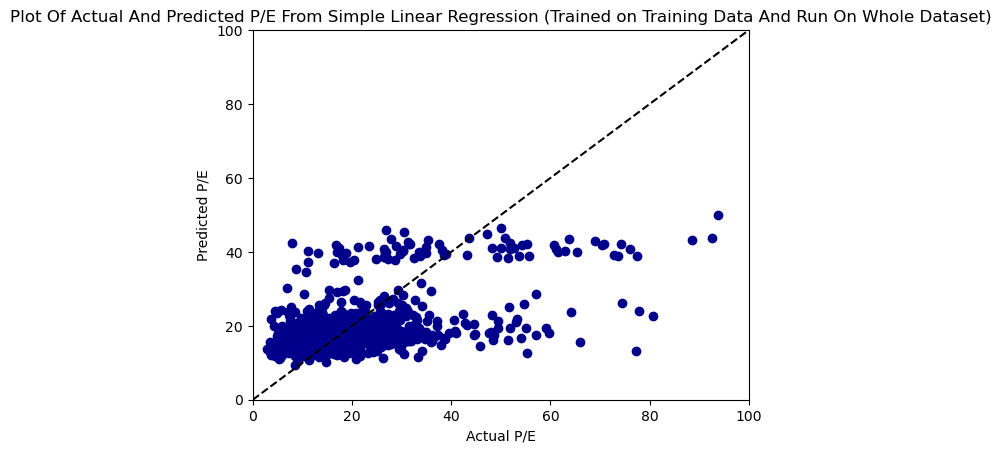

In [29]:
# Scatter plot across the whole dataset for linear regression.

plt.scatter(y_actual_non_standardised, ((reg.predict(X_nn_input) * y_std) + y_mean), c = 'darkblue')
plt.plot([0, 100], [0, 100], color = 'black', linestyle = 'dashed')
plt.xlabel("Actual P/E")
plt.ylabel("Predicted P/E")
plt.title("Plot Of Actual And Predicted P/E From Simple Linear Regression (Trained on Training Data And Run On Whole Dataset)")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

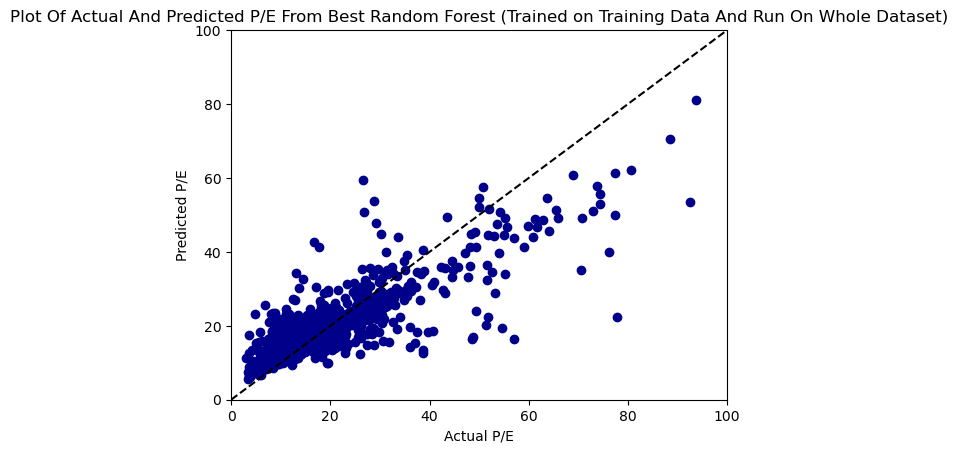

In [30]:
# Scatter plot across the whole dataset for the best random forest model.

plt.scatter(y_actual_non_standardised, ((random_forest_classifier_best.predict(X_full) * y_std) + y_mean), c = 'darkblue')
plt.plot([0, 100], [0, 100], color = 'black', linestyle = 'dashed')
plt.xlabel("Actual P/E")
plt.ylabel("Predicted P/E")
plt.title("Plot Of Actual And Predicted P/E From Best Random Forest (Trained on Training Data And Run On Whole Dataset)")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()
plt.show()

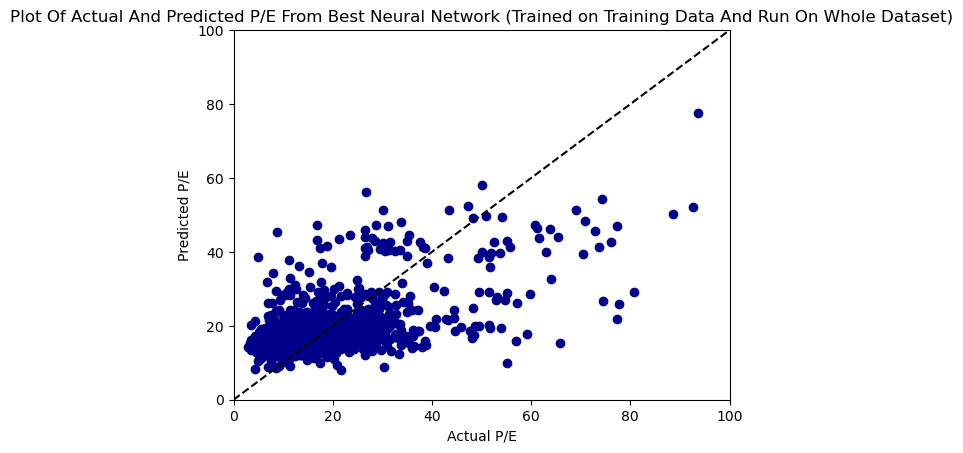

In [31]:
# Scatter plot across the whole dataset for the best neural network.

y_pred_full = best_model(X_full_tensor)
y_pred_full = y_pred_full.detach().numpy()
y_pred_full_non_standardised = ((y_pred_full * y_std) + y_mean)

plt.scatter(y_actual_non_standardised, y_pred_full_non_standardised, c = 'darkblue')
plt.plot([0, 100], [0, 100], color = 'black', linestyle = 'dashed')
plt.xlabel("Actual P/E")
plt.ylabel("Predicted P/E")
plt.title("Plot Of Actual And Predicted P/E From Best Neural Network (Trained on Training Data And Run On Whole Dataset)")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()